In [2]:
import scipy.ndimage
import xarray as xr 
import numpy as np 
import cmaps as cmap 
import matplotlib.pyplot as plt
import scipy 
import warnings
import matplotlib.patheffects as pe
from scipy.ndimage import gaussian_filter
from matplotlib import rcParams
from helper import helicity 

warnings.filterwarnings("ignore")
rcParams['font.family'] = 'Courier New'

def Gradient2D(data):
    # Define gradient vector as <fx, fy>
    # Compute the derivative of the dataset, A, in x and y directions, accounting for dimensional changes due to centered differencing
    dAx = data.diff('longitude')[1:, :]
    dAy = data.diff('latitude')[:, 1:]

    # Compute the derivative of both the x and y coordinates
    dx = data['longitude'].diff('longitude') * np.cos(data['latitude'] * (np.pi / 180)) 
    dy = data['latitude'].diff('latitude')

    # Return dA/dx and dA/dy, where A is the original dataset
    return dAx / dx, dAy / dy

def labels(ax, flag = False):
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    if flag == False:
        ax.text(1 * np.pi / 4, 2, 'Downtilt\nRight', size = 12, color = 'black', horizontalalignment = 'center', fontfamily = 'Courier New', fontweight = 'bold', path_effects=[pe.withStroke(linewidth=2.25, foreground="white")], verticalalignment = 'center')
        ax.text(3 * np.pi / 4, 2, 'Uptilt\nRight', size = 12, color = 'black', horizontalalignment = 'center', fontfamily = 'Courier New', fontweight = 'bold', path_effects=[pe.withStroke(linewidth=2.25, foreground="white")], verticalalignment = 'center')
        ax.text(5 * np.pi / 4, 2, 'Uptilt\nLeft', size = 12, color = 'black', horizontalalignment = 'center', fontfamily = 'Courier New', fontweight = 'bold', path_effects=[pe.withStroke(linewidth=2.25, foreground="white")], verticalalignment = 'center')
        ax.text(7 * np.pi / 4, 2, 'Downtilt\nLeft', size = 12, color = 'black', horizontalalignment = 'center', fontfamily = 'Courier New', fontweight = 'bold', path_effects=[pe.withStroke(linewidth=2.25, foreground="white")], verticalalignment = 'center')
        
        ax.annotate('', xy=(0, 0.5), xytext=(np.pi, 0.5),
                arrowprops=dict(facecolor='black', edgecolor='black', width=1, headwidth=8, headlength=10, path_effects=[pe.withStroke(linewidth=2.25, foreground="white")]))

    ax.set_yticklabels(['', '', 'RMW', '', '2xRMW', '', '3xRMW', '', ''], fontfamily = 'Courier New', path_effects=[pe.withStroke(linewidth=2.25, foreground="white")])
    ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'], fontfamily = 'Courier New', path_effects=[pe.withStroke(linewidth=2.25, foreground="white")])

def rePoPolar(dataset, offset = 0):
    x = dataset.longitude.values
    y = dataset.latitude.values
    x, y = np.meshgrid(x, y)

    r = np.sqrt(x**2 + y**2)
    t = np.arctan2(y, x)

    rBins = np.linspace(np.nanmin(r), np.nanmax(r), 200)
    tBins = np.linspace(np.nanmin(t), np.nanmax(t), 2000)

    for i in range(len(tBins)):
            tBins[i] = tBins[i] + offset
            while tBins[i] <= (-1 * np.pi):
                tBins[i] = tBins[i] + (2 * np.pi)
            while tBins[i] >= np.pi:
                tBins[i] = tBins[i] - (2 * np.pi)

    R, T = np.meshgrid(rBins, tBins)
    newX, newY = R * np.cos(T), R * np.sin(T)
    gridded_data = scipy.interpolate.griddata((x.flatten(), y.flatten()), dataset.values.flatten(), (newX.flatten(), newY.flatten()), method='nearest')

    polar = xr.Dataset(
        {
            'data': (('r', 'theta'), gridded_data.reshape(R.shape).transpose())
        },
        coords={
            'r': rBins,
            'theta': tBins
        }
    )

    return polar


def getData(dataset, var, levels, case):
    vmax = dataset['vmax_ships'].sel(num_cases = case, ships_lag_times = 0).values
    rmw = dataset['tc_rmw'].sel(num_cases = case, height = 3).values / 2
    # shd = 360 - dataset['sddc_ships'].sel(num_cases = case, ships_lag_times = 0).values
    shd = 180 - np.nanmax(dataset['tc_tilt_direction'].sel(num_cases = case, height = [5, 5.5, 6.0, 6.5]).values) * (180 / np.pi)

    print('Shear direction', shd)
    print('Radius of Max Wind:', rmw)
    data = []
    for x in range(len(var)):
        temp = dataset['swath_tangential_wind'].sel(num_cases = case, height = levels[x])

        offset = (np.pi / 2) + np.deg2rad(shd)
        temp = rePoPolar(temp, offset)
        temp['r'] = temp['r'] / rmw
        rad = 4
        temp = temp['data'].sel(r = slice(0, rad))
        temp.values = np.flip(temp.values, axis = 1)
        newR = np.linspace(0, rad, 200)
        temp = temp.interp(r = newR)

        # fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
        # ax.set_theta_zero_location("N")
        # ax.set_theta_direction(-1)
        # plt.pcolormesh(temp.theta, temp.r, temp.values)
        # plt.show()

        data.append(temp)    
    return data, vmax

def makeComposites(dataset, list):
    dataset = dataset.assign_coords(longitude=((dataset.longitude - 100)).sortby('longitude'))
    dataset = dataset.assign_coords(latitude=((dataset.latitude - 100)).sortby('latitude'))

    refl = []
    winds = []
    for x in range(len(list)):
        dat, vmax = getData(dataset, ['swath_reflectivity'], [3], list[x])

        refl.append(dat[0])
        winds.append(vmax)

    return refl, winds

dataset1 = xr.open_dataset(r"C:\Users\deela\Downloads\tc_radar_v3l_1997_2019_xy_rel_swath_ships.nc")
dataset2 = xr.open_dataset(r"C:\Users\deela\Downloads\tc_radar_v3l_2020_2023_xy_rel_swath_ships.nc")

# if t == 'Decrease2':
#     # Decrease 10km (<75kt)
#     list1 = [155.0, 167.0, 223.0, 255.0, 282.0, 287.0, 306.0, 311.0, 319.0, 332.0, 347.0, 374.0, 376.0, 407.0, 413.0, 424.0, 427.0, 431.0, 451.0, 510.0, 524.0, 678.0]
#     list2 = [10.0, 18.0, 29.0, 35.0, 55.0, 61.0, 164.0, 166.0, 186.0, 187.0, 197.0, 205.0, 229.0, 232.0, 245.0, 249.0, 255.0, 347.0, 352.0, 358.0, 420.0, 426.0, 464.0, 467.0, 468.0, 471.0, 510.0, 516.0, 586.0] 
# elif t == 'Decrease':
#     # Decrease 10km (all storms)
#     list1 = [155.0, 167.0, 176.0, 223.0, 255.0, 282.0, 287.0, 306.0, 311.0, 319.0, 332.0, 347.0, 374.0, 376.0, 407.0, 413.0, 424.0, 427.0, 431.0, 438.0, 451.0, 465.0, 510.0, 524.0, 533.0, 536.0, 566.0, 570.0, 606.0, 652.0, 678.0]
#     list2 = [10.0, 18.0, 24.0, 29.0, 35.0, 55.0, 61.0, 67.0, 87.0, 101.0, 108.0, 139.0, 148.0, 164.0, 166.0, 186.0, 187.0, 197.0, 205.0, 229.0, 232.0, 245.0, 249.0, 255.0, 347.0, 352.0, 358.0, 364.0, 374.0, 404.0, 420.0, 426.0, 464.0, 467.0, 468.0, 471.0, 510.0, 516.0, 540.0, 548.0, 565.0, 586.0, 604.0]        
# elif t == 'Increase':
#     # Increase 10km (all storms)
#     list1 = [99.0, 168.0, 220.0, 284.0, 308.0, 312.0, 313.0, 345.0, 375.0, 402.0, 422.0, 425.0, 545.0, 561.0, 580.0]
#     list2 = [21.0, 26.0, 32.0, 37.0, 58.0, 129.0, 142.0, 149.0, 164.0, 226.0, 349.0, 358.0, 464.0, 474.0, 487.0, 512.0, 529.0, 587.0, 605.0]
# else:
#     list1 = [488]
#     list2 = []

alignment1 = [225,251,252,253,254,333,334,347,374,376,377,407,408,409,410,413,414,603,604,605,672]
alignment2 = [719,752,765,767,794,878,879,939,941,957,968,969,970,971,1057,1073,1101,1131,1148,1177,1178,1179,1180,1191,1192,1220,1222,1223,1224,1226,1227,1228,1301,1302,1305]
alignment2 = [x - 710 for x in alignment2]

nonaligning1 = [148,149,222,224,339,340,341,342,343,344,382,383,384,402,423,424,425,426,427,429,430,431,545,600,601]
nonaligning2 = [742,744,745,747,869,898,899,918,919,930,934,935,936,1040,1049,1175,1195,1197,1201,1217,1218]
nonaligning2 = [x - 710 for x in nonaligning2]

In [3]:
print(list(dataset1.variables))

['num_cases', 'height', 'ships_lag_times', 'original_longitudes', 'original_latitudes', 'recentered_longitudes', 'recentered_latitudes', 'total_recentered_longitudes', 'total_recentered_latitudes', 'eastward_distance', 'northward_distance', 'original_fix_longitude', 'original_fix_latitude', 'tc_center_longitudes', 'tc_center_latitudes', 'tc_rmw', 'swath_coverage', 'mission_ID', 'storm_name', 'swath_year', 'swath_month', 'swath_day', 'swath_hour', 'swath_min', 'beg_swath_year', 'beg_swath_month', 'beg_swath_day', 'beg_swath_hour', 'beg_swath_min', 'end_swath_year', 'end_swath_month', 'end_swath_day', 'end_swath_hour', 'end_swath_min', 'tc_eastward_tilt', 'tc_northward_tilt', 'tc_tilt_magnitude', 'tc_tilt_direction', 'swath_eastward_wind', 'swath_northward_wind', 'swath_upward_air_velocity', 'swath_reflectivity', 'swath_wind_speed', 'swath_radial_wind', 'swath_tangential_wind', 'swath_earth_relative_eastward_wind', 'swath_earth_relative_northward_wind', 'swath_relative_vorticity', 'swath

In [6]:
refl1, wind1 = makeComposites(dataset1, alignment1)
refl2, wind2 = makeComposites(dataset2, alignment2)

refl = refl1 + refl2
wind = wind1 + wind2
meanWind = np.nanmean(wind)
mediWind = np.nanmedian(wind)
print(meanWind, mediWind)
# test = xr.merge(refl, compat = 'override')
test = xr.concat(refl, dim='case')
test = test.interp(theta = np.linspace(-1 * np.pi, np.pi, 2000))
tCoords = test.theta
rcoords = refl[0].r

temp = []
for x in range(len(refl)):
    temp.append(refl[x].sel(r = 1, method = 'nearest'))

aligning = np.array(temp)
aligning = np.nanmean(aligning, axis = 0)
print(aligning.shape)

Shear direction 107.4027
Radius of Max Wind: 88.0
Shear direction 141.3402
Radius of Max Wind: 28.0
Shear direction 192.99461
Radius of Max Wind: 48.0
Shear direction 175.23636
Radius of Max Wind: 29.0
Shear direction 127.874985
Radius of Max Wind: 32.0
Shear direction 192.09476
Radius of Max Wind: 35.0
Shear direction 180.0
Radius of Max Wind: 59.0
Shear direction 233.82037
Radius of Max Wind: 52.0
Shear direction 180.0
Radius of Max Wind: 76.0
Shear direction 173.6598
Radius of Max Wind: 74.0
Shear direction 153.43495
Radius of Max Wind: 15.0
Shear direction 220.91438
Radius of Max Wind: 69.0
Shear direction 231.3402
Radius of Max Wind: 61.0
Shear direction 232.12502
Radius of Max Wind: 75.0
Shear direction 208.0725
Radius of Max Wind: 71.0
Shear direction 203.9625
Radius of Max Wind: 88.0
Shear direction 184.08562
Radius of Max Wind: 54.0
Shear direction 229.39871
Radius of Max Wind: 53.0
Shear direction 242.24146
Radius of Max Wind: 33.0
Shear direction 221.18593
Radius of Max Wind

In [7]:
refl1, wind1 = makeComposites(dataset1, nonaligning1)
refl2, wind2 = makeComposites(dataset2, nonaligning2)

refl = refl1 + refl2
wind = wind1 + wind2
meanWind = np.nanmean(wind)
mediWind = np.nanmedian(wind)
print(meanWind, mediWind)
# test = xr.merge(refl, compat = 'override')
test = xr.concat(refl, dim='case')
test = test.interp(theta = np.linspace(-1 * np.pi, np.pi, 2000))
tCoords = test.theta
rcoords = refl[0].r

temp = []
for x in range(len(refl)):
    temp.append(refl[x].sel(r = 1, method = 'nearest'))

nonaligning = np.array(temp)
nonaligning = np.nanmean(nonaligning, axis = 0)

Shear direction 162.47443
Radius of Max Wind: 86.0
Shear direction 174.93639
Radius of Max Wind: 85.0
Shear direction 121.6075
Radius of Max Wind: 33.0
Shear direction 120.25644
Radius of Max Wind: 40.0
Shear direction 219.09386
Radius of Max Wind: 53.0
Shear direction 214.69516
Radius of Max Wind: 88.0
Shear direction 186.009
Radius of Max Wind: 60.0
Shear direction 180.0
Radius of Max Wind: 81.0
Shear direction 191.88866
Radius of Max Wind: 85.0
Shear direction 180.0
Radius of Max Wind: 64.0
Shear direction 220.91438
Radius of Max Wind: 41.0
Shear direction 201.37062
Radius of Max Wind: 41.0
Shear direction 207.0506
Radius of Max Wind: 57.0
Shear direction 240.64224
Radius of Max Wind: 73.0
Shear direction 50.710587
Radius of Max Wind: 88.0
Shear direction 48.81407
Radius of Max Wind: 54.0
Shear direction 32.735214
Radius of Max Wind: 85.0
Shear direction 36.86989
Radius of Max Wind: 21.0
Shear direction 34.1597
Radius of Max Wind: 60.0
Shear direction 37.69423
Radius of Max Wind: 72

In [25]:
s = 0
aligning_smoothed = gaussian_filter(aligning, s)
nonaligning_smoothed = gaussian_filter(nonaligning, s)

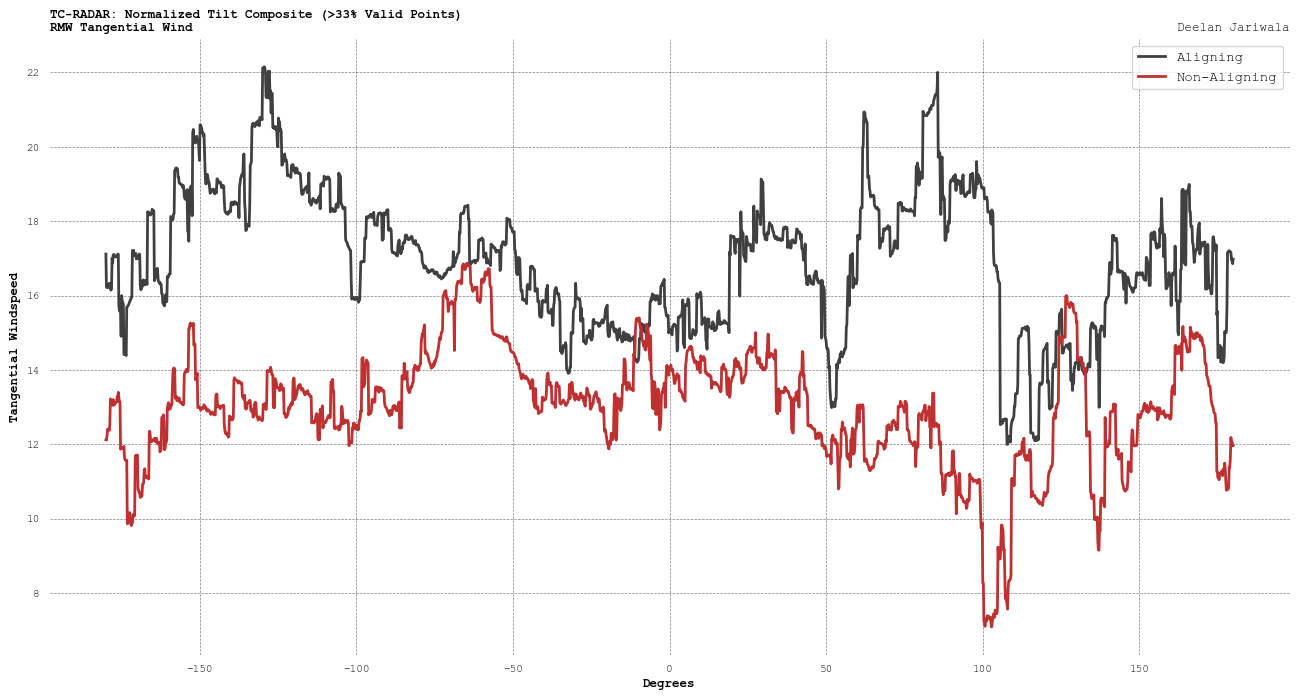

In [26]:
fig = plt.figure(figsize=(16, 8))

# Add the map and set the extent
ax = plt.axes()
ax.set_frame_on(False)

# Add state boundaries to plot
ax.tick_params(axis='both', labelsize=8, left = False, bottom = False)
ax.grid(linestyle = '--', alpha = 0.5, color = 'black', linewidth = 0.5, zorder = 9)
ax.set_ylabel('Tangential Windspeed', weight = 'bold', size = 9)
ax.set_xlabel('Degrees', weight = 'bold', size = 9)

ax.plot(tCoords, aligning_smoothed, linewidth = 2, color = '#404040', label = 'Aligning')
ax.plot(tCoords, nonaligning_smoothed, linewidth = 2, color = '#bf3030', label = 'Non-Aligning')

plt.legend()

ax.set_title(f'TC-RADAR: Normalized Tilt Composite (>33% Valid Points)\nRMW Tangential Wind', fontweight='bold', fontsize=9, loc='left')
ax.set_title(f'Deelan Jariwala', fontsize=9, loc='right') 
plt.savefig(r"C:\Users\deela\Downloads\TCTiltProject\NEWtdrcomp_tangentialwind_rmw.png", dpi = 400, bbox_inches = 'tight')
plt.show()

In [5]:
print(aligning)

[nan nan nan ... nan nan nan]
